# Exercise 2: Convolution GAN for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cpu


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [2]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3797702.37it/s] 


Extracting c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw\train-images-idx3-ubyte.gz to c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 354367.87it/s]


Extracting c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw\train-labels-idx1-ubyte.gz to c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 825623.11it/s] 


Extracting c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw\t10k-images-idx3-ubyte.gz to c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw\t10k-labels-idx1-ubyte.gz to c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA206\TP2 - WGAN\MNIST\raw



QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


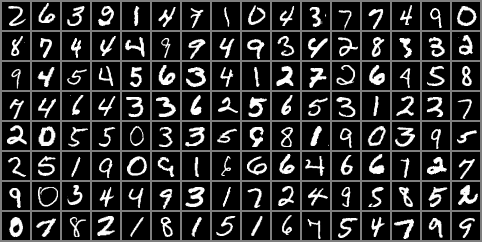

In [3]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

In [4]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


### Generator Architecture:
- **Purpose**: To transform a latent space vector into a data-space image.
- **Input Size**: The input to the generator is a noise vector of size `nz` (100).
- **Layers Overview**:
  1. **First Layer**: A transpose convolution (`nn.ConvTranspose2d`) that expands the `nz`-dimensional input into a tensor of shape (ngf*8) x 4 x 4 (512 x 4 x 4 assuming ngf=64).
  2. **Middle Layers**: Multiple layers of transpose convolutions that gradually upsample the spatial dimensions of the feature maps. Each layer doubles the height and width of the feature maps while halving the depth, moving from ngf*8 to ngf through sequential halving steps, and incorporates batch normalization and ReLU activations to stabilize training and introduce non-linearity.
  3. **Final Layer**: A transpose convolution that maps the ngf feature maps into a single channel output image with a kernel size adjusted (1x1 kernel with padding of 2) to produce a 28x28 output, followed by a `Tanh` activation to scale the output pixel values between -1 and 1.

### Discriminator Architecture:
- **Purpose**: To classify 28x28 pixel images as real or fake.
- **Input Size**: Accepts 1-channel images of size 28x28.
- **Layers Overview**:
  1. **First Layer**: A standard convolution (`nn.Conv2d`) that reduces the spatial dimensions from 28x28 to a smaller feature map (15x15), doubling the depth from the single channel to `ndf` (assuming ndf=64).
  2. **Middle Layers**: Successive convolutions continue to halve the spatial dimensions while increasing the depth. Each convolution is followed by batch normalization and LeakyReLU activations. The feature map depth increases through these layers, doubling at each step, from ndf to ndf*4.
  3. **Final Layer**: A convolution that reduces the spatial dimension further, intending to collapse the spatial dimensions fully into a single value (dimensionality reduction to 1), with the output intended to represent the discriminator's logit for whether the input is real or fake.

The generator uses `ReLU` and `Tanh` to ensure the outputs are normalized, while the discriminator uses `LeakyReLU` to allow gradients to flow even for negative values, preventing "dying ReLU" issues. The generator outputs a 28x28 image which is typical for working with datasets like MNIST, and the discriminator's final output is shaped to give a single scalar per image, indicating its authenticity.

## Display Samples of the Generator

In [5]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

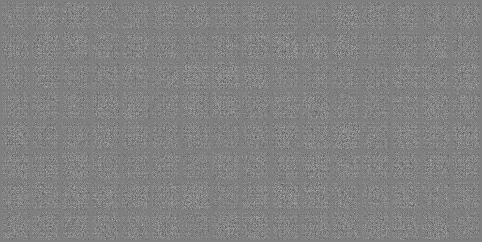

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [7]:
def lipconstant(D, x, y):
    """ Computes an approximation of the Lipschitz constant based on maximum gradient norms seen. """
    # Make sure the gradients are not tracked for this calculation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    pred_x = D(x)
    pred_y = D(y)
    
    # Calculate gradients
    grad_x = torch.autograd.grad(outputs=pred_x, inputs=x,
                                 grad_outputs=torch.ones(pred_x.size(), device=x.device),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_y = torch.autograd.grad(outputs=pred_y, inputs=y,
                                 grad_outputs=torch.ones(pred_y.size(), device=y.device),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    # Calculate norms of gradients
    norm_x = grad_x.view(grad_x.size(0), -1).norm(2, dim=1)
    norm_y = grad_y.view(grad_y.size(0), -1).norm(2, dim=1)
    
    # Use max gradient norm as a proxy for the Lipschitz constant
    lip_const = max(torch.max(norm_x).item(), torch.max(norm_y).item())
    
    return lip_const

def gradient_penalty(D, x, y):
    """ Computes the gradient penalty for enforcing the Lipschitz constraint for WGAN-GP. """
    batch_size = x.size(0)
    # Random weight for interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, 1, 1, device=x.device)
    alpha = alpha.expand_as(y)

    # Interpolated images
    interpolated = alpha * y + (1 - alpha) * x
    interpolated.requires_grad_(True)

    # Calculate D's prediction on the interpolated images
    pred = D(interpolated)

    # Get gradients of D with respect to the interpolated images
    gradients = torch.autograd.grad(outputs=pred, inputs=interpolated,
                                    grad_outputs=torch.ones(pred.size(), device=x.device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)

    # Gradient penalty 
    penalty = ((gradient_norm - 1)**2).mean()
    
    return penalty


y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

9.957212448120117
tensor(0.5246, grad_fn=<MeanBackward0>)


[1/5][0/468][15.5691 s]	Loss_D: 0.0877	Loss_G: 1.4651	Lip(D): 8.7614


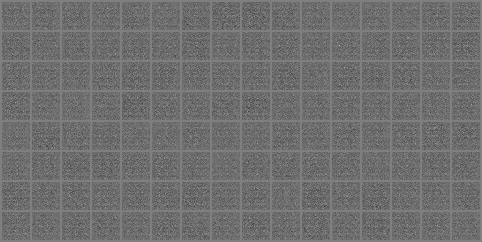

[1/5][100/468][277.0240 s]	Loss_D: -6.6109	Loss_G: 7.9884	Lip(D): 13.5694


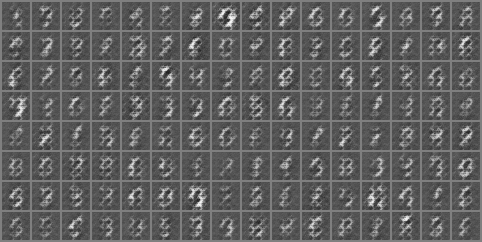

[1/5][200/468][557.9066 s]	Loss_D: -32.9547	Loss_G: 19.9932	Lip(D): 36.4106


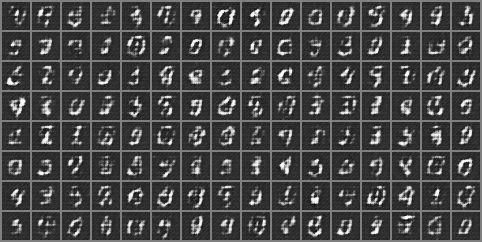

[1/5][300/468][834.1273 s]	Loss_D: -62.6767	Loss_G: 41.3136	Lip(D): 83.1031


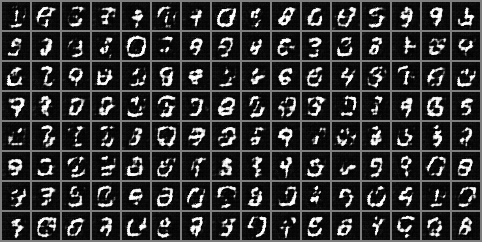

[1/5][400/468][1110.6773 s]	Loss_D: -28.0271	Loss_G: 74.1868	Lip(D): 135.0279


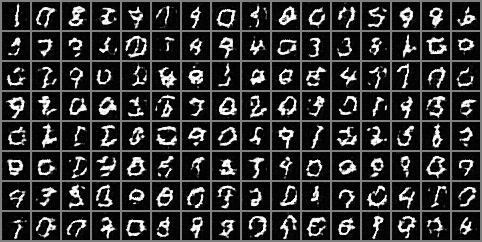

[2/5][0/468][1302.3369 s]	Loss_D: -47.5459	Loss_G: 39.4281	Lip(D): 173.9054


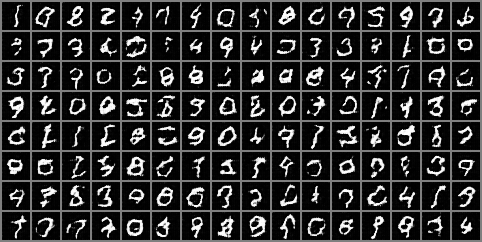

[2/5][100/468][1569.6537 s]	Loss_D: -35.4843	Loss_G: 38.5061	Lip(D): 165.8904


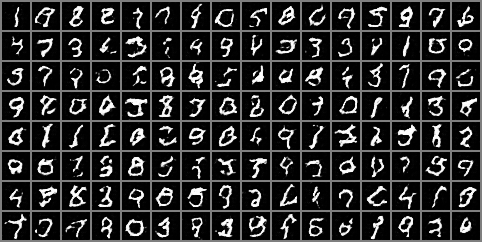

[2/5][200/468][1861.6431 s]	Loss_D: -12.1808	Loss_G: 49.0308	Lip(D): 275.7996


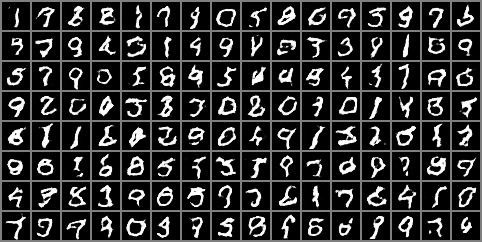

[2/5][300/468][2140.8932 s]	Loss_D: -26.0995	Loss_G: 50.6748	Lip(D): 302.7483


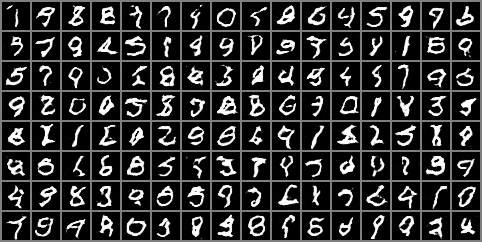

[2/5][400/468][2408.9980 s]	Loss_D: -45.4559	Loss_G: 95.9844	Lip(D): 213.1530


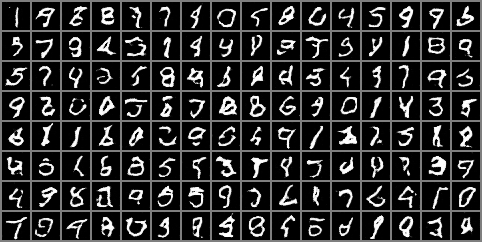

[3/5][0/468][2604.1330 s]	Loss_D: -27.5546	Loss_G: 62.2984	Lip(D): 266.1729


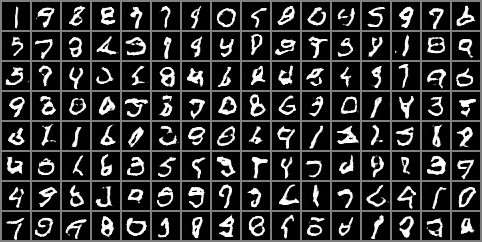

[3/5][100/468][2886.4592 s]	Loss_D: -37.9659	Loss_G: 52.1507	Lip(D): 278.3290


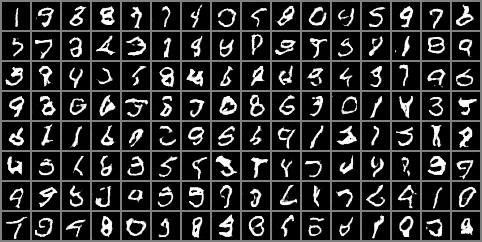

[3/5][200/468][3174.4824 s]	Loss_D: -0.9345	Loss_G: 12.3038	Lip(D): 242.6205


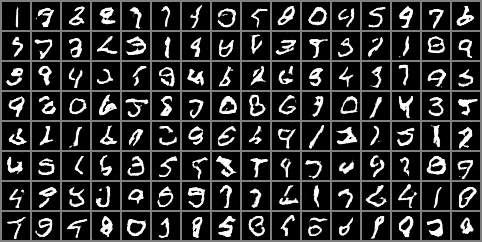

[3/5][300/468][3467.7926 s]	Loss_D: -29.7805	Loss_G: 89.5323	Lip(D): 313.4416


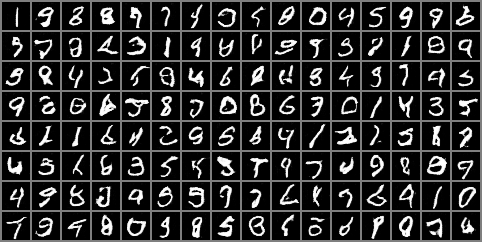

[3/5][400/468][3771.0912 s]	Loss_D: -27.9346	Loss_G: 58.3829	Lip(D): 249.3760


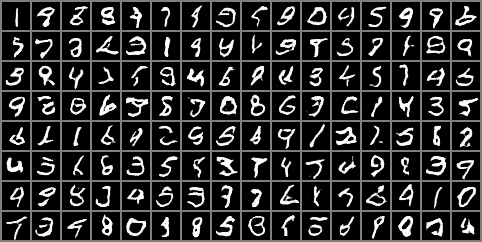

[4/5][0/468][3972.8370 s]	Loss_D: -6.8218	Loss_G: 54.0650	Lip(D): 269.4881


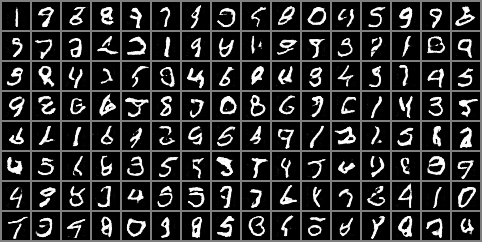

[4/5][100/468][4263.4870 s]	Loss_D: -33.8756	Loss_G: 4.2081	Lip(D): 341.1071


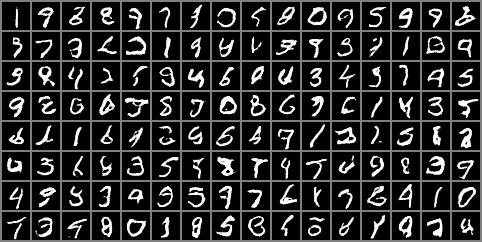

[4/5][200/468][4541.2419 s]	Loss_D: -39.6974	Loss_G: 149.8037	Lip(D): 282.7868


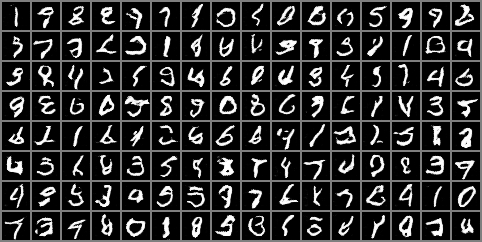

[4/5][300/468][4818.5919 s]	Loss_D: -32.1729	Loss_G: 86.1779	Lip(D): 318.3340


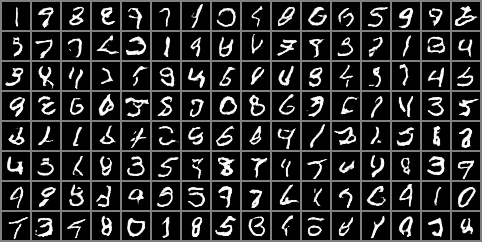

[4/5][400/468][5095.8018 s]	Loss_D: -23.4195	Loss_G: 48.9652	Lip(D): 268.1227


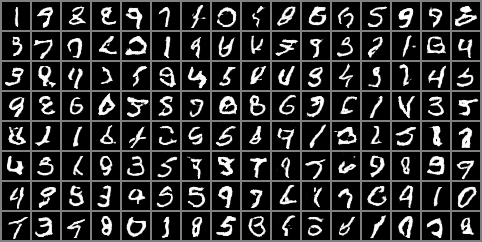

[5/5][0/468][5294.8059 s]	Loss_D: -0.6474	Loss_G: 77.7447	Lip(D): 309.4062


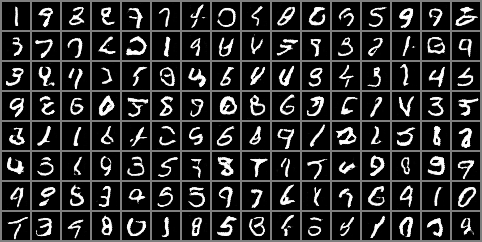

[5/5][100/468][5570.7046 s]	Loss_D: -31.0200	Loss_G: 105.1018	Lip(D): 255.2477


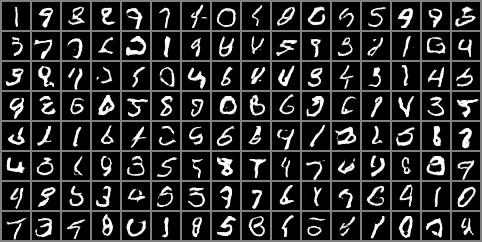

[5/5][200/468][5843.7261 s]	Loss_D: -32.3741	Loss_G: 134.4103	Lip(D): 321.4013


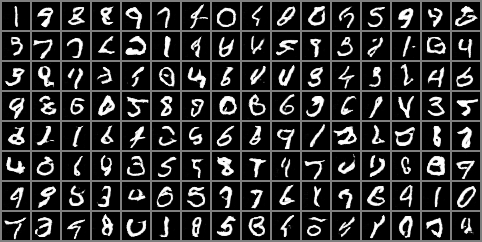

[5/5][300/468][6118.5610 s]	Loss_D: -10.5004	Loss_G: 165.7212	Lip(D): 161.4632


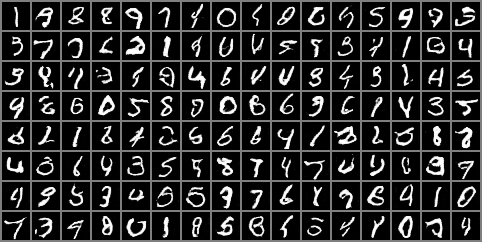

[5/5][400/468][6409.2759 s]	Loss_D: -9.6706	Loss_G: 238.4657	Lip(D): 27.2603


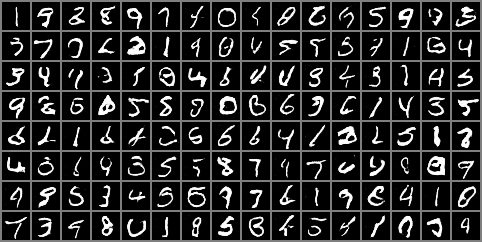

Total learning time =  6608.560831069946


<All keys matched successfully>

In [9]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()
        
        # Train with real
        output_real = D(real)
        lossD_real = -torch.mean(output_real)

        # Train with fake
        output_fake = D(faked)
        lossD_fake = torch.mean(output_fake)

        # Compute the gradient penalty
        penalty = gradient_penalty(D, real, faked) * gpw
        Dloss = lossD_real + lossD_fake + penalty
        Dloss.backward()
        optimD.step()

        ############################
        # Update G network: maximize log(D(G(z)))
        G.zero_grad()
        output = D(fake)
        Gloss = -torch.mean(output)
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [10]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())

<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


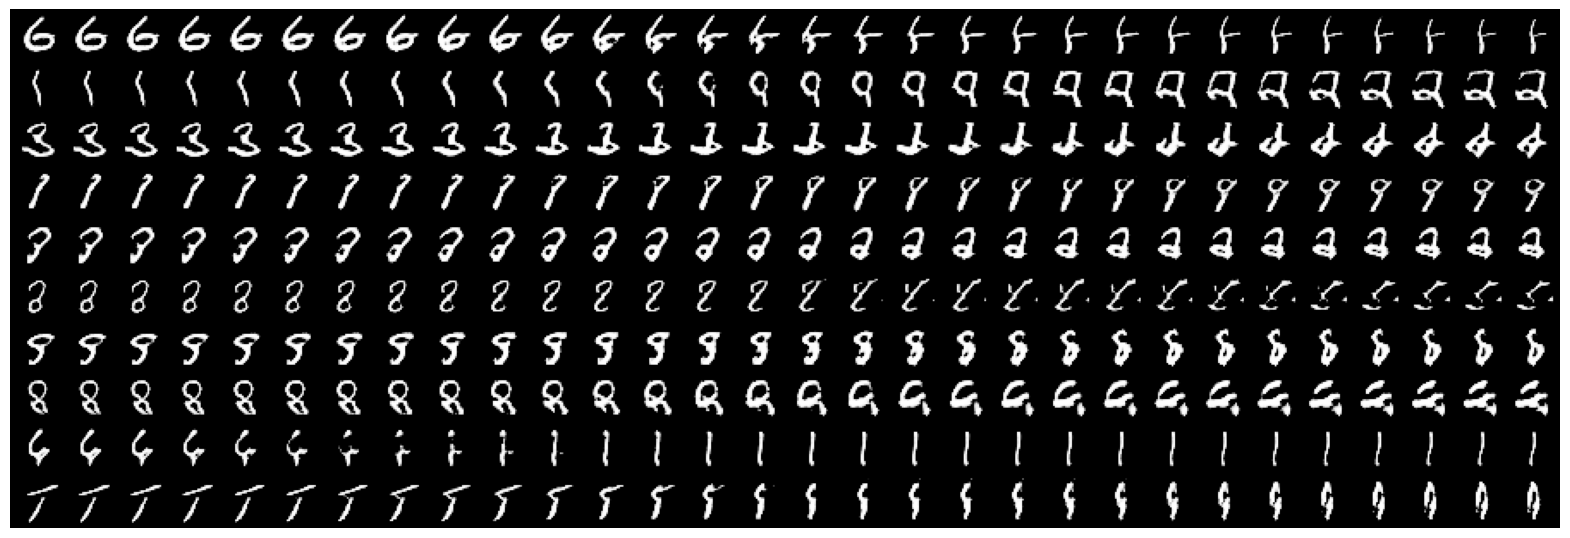

In [13]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

G = Generator().to(device)
G.load_state_dict(torch.load('wgan.pt'))
G.eval()

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
minib = 10  # Number of interpolations
nk = 30     # Number of steps in the interpolation

# Generate random latent vectors z0 and z1
z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

# Prepare tensor to hold all generated images
genimages = torch.zeros((minib * nk, 1, 28, 28), device=device)

# Perform interpolation
for i in range(minib):
    for k in range(nk):
        alpha = k / (nk - 1)
        z_alpha = (1 - alpha) * z0[i:i+1] + alpha * z1[i:i+1]  # Keep the batch dimension
        with torch.no_grad():
            genimages[i * nk + k] = G(z_alpha).detach()

# Move the tensor to CPU for visualization
genimages = genimages.to('cpu')

# Create a grid of images
grid_img = torchvision.utils.make_grid(genimages, nrow=nk, padding=2)

# Plot the grid
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plt.imshow(grid_img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for matplotlib
plt.axis('off')
plt.show()


## Nearest Neighbor in the Dataset

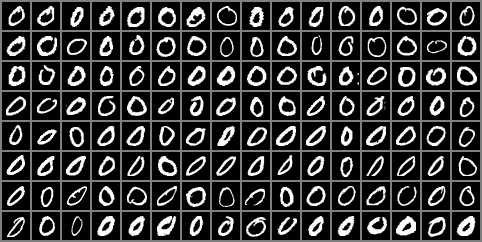

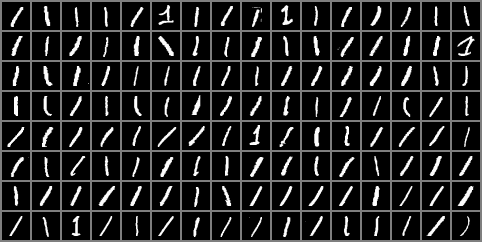

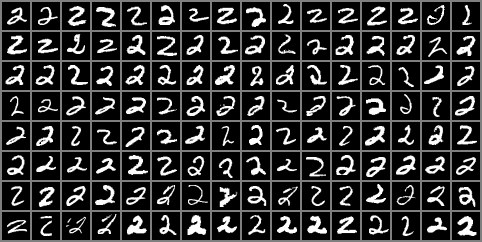

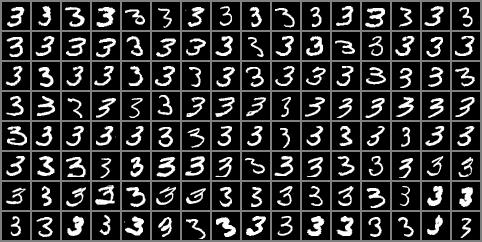

In [14]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated Image 1 and its Nearest Neighbor


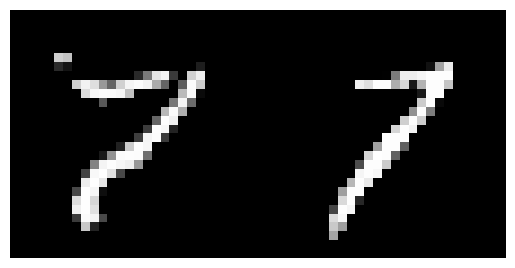

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated Image 2 and its Nearest Neighbor


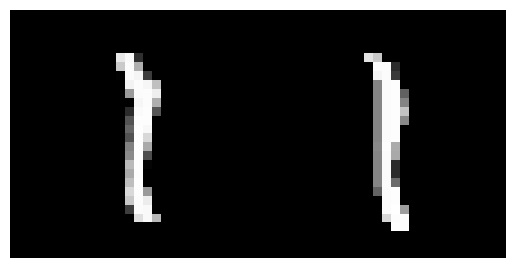

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated Image 3 and its Nearest Neighbor


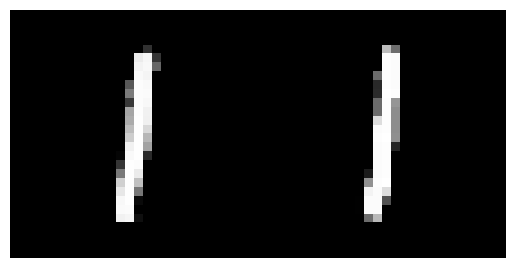

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated Image 4 and its Nearest Neighbor


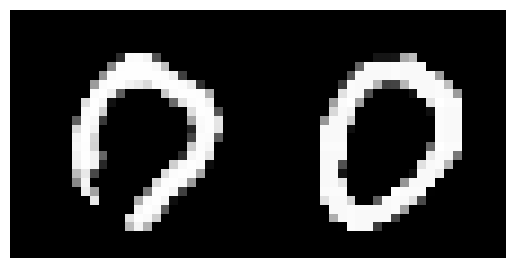

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated Image 5 and its Nearest Neighbor


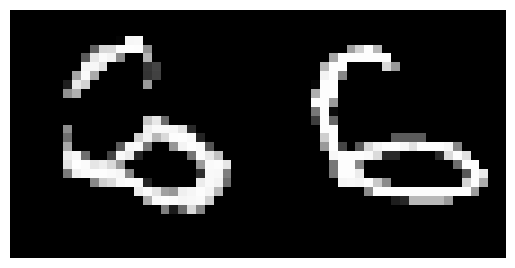

In [15]:
import torch.nn.functional as F

def imshow(img):
    """ Helper function to show an image """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Generate samples
num_samples = 5  # Define how many samples you want to generate
z = torch.randn(num_samples, nz, 1, 1, device=device)
generated_images = G(z).detach()  # Generated images

# Flatten the MNIST dataset images and generated images
flat_data = y.view(y.size(0), -1)  # y is your full dataset loaded as above
flat_generated = generated_images.view(generated_images.size(0), -1)

# Find nearest neighbors
nearest_neighbors = []
for gen_img in flat_generated:
    # Compute distances from this generated image to every image in the dataset
    distances = torch.norm(flat_data - gen_img, dim=1)
    nearest_idx = torch.argmin(distances)
    nearest_neighbors.append(y[nearest_idx])

# Display generated images and their nearest neighbors
for idx, (gen_img, nn_img) in enumerate(zip(generated_images, nearest_neighbors)):
    combined_img = torch.cat((gen_img, nn_img), dim=2)  # Concatenate images side-by-side
    print(f"Generated Image {idx + 1} and its Nearest Neighbor")
    imshow(torchvision.utils.make_grid(combined_img.to('cpu'), nrow=1))
